In [12]:
#https://sentinelsat.readthedocs.io/en/latest/cli.html
# Use sentinelsat to download sentinel-2 data
# note that the geojson file you use to search must be in epsg:4236 (WGS 84 coordinates)

# I ran this on the command line:
# sentinelsat -g singapore_boundary.geojson --sentinel 2 --cloud 5 -d

# Note that not all Sentinel 2 data is not actually hosted online; instead it is hosted on an
# offline database called the LTA (long term archive). When you request this data it will take a 
# while for the data to be extracted from the long term archive after which it will be available
# for three days.

# This is actually a severe issue - only one Sentinel-2 image was available online for Singapore in 
# the past 6 years lmao

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date

# Note that you must remember NOT to include this when using github
api = SentinelAPI('username', 'password', 'https://apihub.copernicus.eu/apihub')

# search by polygon, time, and SciHub query keywords
footprint = geojson_to_wkt(read_geojson('singapore_boundary.geojson'))
products = api.query(footprint,
                     date=('20151219', '20230801'),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 5))

# convert to Pandas DataFrame
products_df = api.to_dataframe(products)

In [16]:
products_df["summary"][0]

'Date: 2023-06-19T03:15:21.024Z, Instrument: MSI, Satellite: Sentinel-2, Size: 730.92 MB'

In [28]:
from tqdm import tqdm

for product_id, product_dict in tqdm(products_df[["summary", "uuid"]].iterrows()):
    # Check if the product is available online or if it is in LTA
    is_online = api.is_online(product_id)
    
    if is_online:
        print(product_dict.iloc[0])

5it [00:01,  4.69it/s]

Date: 2023-03-16T03:15:19.024Z, Instrument: MSI, Satellite: Sentinel-2, Size: 764.81 MB


92it [00:47,  1.92it/s]


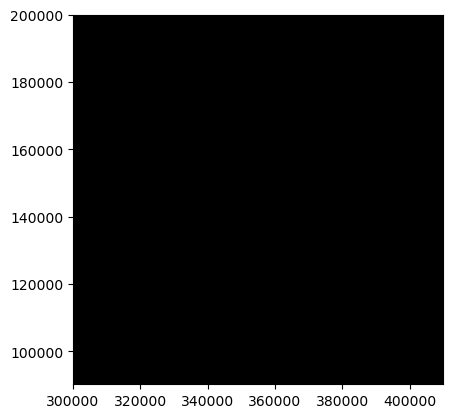

<Axes: >

In [9]:
# The Sentinel 2 images we downloaded (Level 1-C) come with a very basic cloud mask
# https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-1c/cloud-masks

# note that the cloud mask that we are given has a resolution of 60m: consequently you will need to 
# do some resampling before we use it as a real mask

# Alternatively you can use third party cloud mask detection programs to analyze images
# e.g., https://github.com/sentinel-hub/sentinel2-cloud-detector
# relevant paper: https://www.sciencedirect.com/science/article/pii/S0034425722001043?via%3Dihub
import rasterio as rio
from rasterio.plot import show

src = rio.open("MSK_CLASSI_B00.jp2")

mask = src.read()

show(src, cmap = "RdBu", vmin = 0, vmax = 1)

In [12]:
mask[mask != 0] = 255

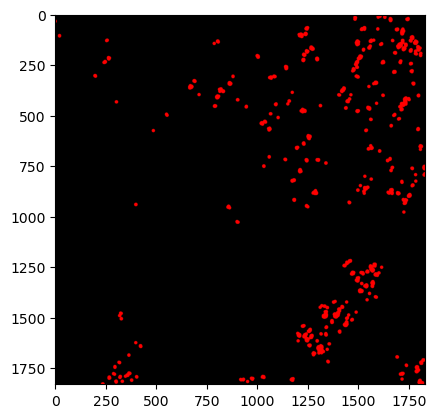

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.imshow(rio.plot.reshape_as_image(mask))